In [10]:
!pip install pandas numpy nltk scikit-learn matplotlib seaborn textblob contractions emoji spacy vaderSentiment wordcloud
!python -m nltk.downloader stopwords wordnet omw-1.4 averaged_perceptron_tagger
!python -m spacy download en_core_web_sm


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 640.0 kB/s eta 0:00:20
     --------------------------------------- 0.1/12.8 MB 660.6 kB/s eta 0:00:20
      --------------------------------------- 0.2/12.8 MB 1.4 MB/s eta 0:00:10
      --------------------------------------- 0.3/12.8 MB 1.7 MB/s eta 0:00:08
      --------------------------------------- 0.3/12.8 MB 1.5 MB/s eta 0:00:09
     - -------------------------------------- 0.4/12.8 MB 1.5 MB/s eta 0:00:09
     - -------------------------------------- 0.4/12.8 MB 1.5 MB/s eta 0:00:09
     - -------------------------------------- 0.5/12.8 MB 1.4 MB/s eta 0:00:09
     - -------------------------------------- 0.5/12.8 MB 1.5 MB/s eta 0:00:09
     - -------------------------------------- 0.6/12.8 MB 1.3 MB/s eta 0:00:10
     - -------------------------------------- 0.6/12.8 MB 


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import contractions
import emoji
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Initialize sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [12]:
# Load CSV file
df = pd.read_csv(r"sample.csv")

# Remove duplicates and nulls
df.drop_duplicates(subset='text', inplace=True)
df.dropna(subset=['text'], inplace=True)

df.head()


tweet_id     author_id  inbound                      created_at  \
0    119237        105834     True  Wed Oct 11 06:55:44 +0000 2017   
1    119238  ChaseSupport    False  Wed Oct 11 13:25:49 +0000 2017   
2    119239        105835     True  Wed Oct 11 13:00:09 +0000 2017   
3    119240  VirginTrains    False  Tue Oct 10 15:16:08 +0000 2017   
4    119241        105836     True  Tue Oct 10 15:17:21 +0000 2017   

                                                text response_tweet_id  \
0  @AppleSupport causing the reply to be disregar...            119236   
1  @105835 Your business means a lot to us. Pleas...               NaN   
2  @76328 I really hope you all change but I'm su...            119238   
3  @105836 LiveChat is online at the moment - htt...            119241   
4  @VirginTrains see attached error message. I've...            119243   

   in_response_to_tweet_id  
0                      NaN  
1                 119239.0  
2                      NaN  
3                 119242.0  
4                 119240.0

In [13]:
def expand_contractions(text):
    return contractions.fix(text)

def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

def clean_text(text):
    text = text.lower()
    text = expand_contractions(text)
    text = remove_emojis(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    filler_words = r'\b(rr+|uh+|umm+|hmm+|ya+|huh+|ah+)\b'
    text = re.sub(filler_words, '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['cleaned_text'] = df['text'].apply(clean_text)
df[['text', 'cleaned_text']].head()


text  \
0  @AppleSupport causing the reply to be disregar...   
1  @105835 Your business means a lot to us. Pleas...   
2  @76328 I really hope you all change but I'm su...   
3  @105836 LiveChat is online at the moment - htt...   
4  @VirginTrains see attached error message. I've...   

                                        cleaned_text  
0  causing the reply to be disregarded and the ta...  
1  your business means a lot to us please dm your...  
2  i really hope you all change but i am sure you...  
3  livechat is online at the moment or contact op...  
4  see attached error message i have tried leavin...

In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    try:
        text = str(TextBlob(text).correct())  # Grammar/spelling correction
    except:
        pass
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

df['processed_text'] = df['cleaned_text'].apply(preprocess)
df[['cleaned_text', 'processed_text']].head()


cleaned_text  \
0  causing the reply to be disregarded and the ta...   
1  your business means a lot to us please dm your...   
2  i really hope you all change but i am sure you...   
3  livechat is online at the moment or contact op...   
4  see attached error message i have tried leavin...   

                                      processed_text  
0  causing reply disregarded tapped ratification ...  
1  business mean lot u please name zip code addit...  
2                            really hope change sure  
3  livechat online moment contact option leave me...  
4  see attached error message tried leaving voice...

In [16]:
def word_count(text):
    return len(text.split())

df['original_word_count'] = df['text'].apply(word_count)
df['cleaned_word_count'] = df['cleaned_text'].apply(word_count)
df['processed_word_count'] = df['processed_text'].apply(word_count)

print("Average original word count:", df['original_word_count'].mean())
print("Average cleaned word count:", df['cleaned_word_count'].mean())
print("Average processed word count:", df['processed_word_count'].mean())


Average original word count: 20.548387096774192
Average cleaned word count: 19.161290322580644
Average processed word count: 9.182795698924732


In [17]:
def ner_pos_analysis(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    pos_tags = [(token.text, token.pos_) for token in doc]
    return entities, pos_tags

df['ner_pos'] = df['processed_text'].head(5).apply(ner_pos_analysis)
df['ner_pos'].head()


0    ([], [(causing, VERB), (reply, NOUN), (disrega...
1    ([], [(business, NOUN), (mean, VERB), (lot, NO...
2    ([], [(really, ADV), (hope, AUX), (change, VER...
3    ([], [(livechat, DET), (online, ADJ), (moment,...
4    ([(several time past week, DATE)], [(see, VERB...
Name: ner_pos, dtype: object

In [18]:
def get_sentiment_scores(text):
    return sentiment_analyzer.polarity_scores(text)

df['sentiment'] = df['processed_text'].apply(get_sentiment_scores)
df = pd.concat([df.drop(['sentiment'], axis=1), df['sentiment'].apply(pd.Series)], axis=1)

df[['processed_text', 'compound', 'pos', 'neu', 'neg']].head()


processed_text  compound    pos    neu  \
0  causing reply disregarded tapped ratification ...   -0.3818  0.000  0.698   
1  business mean lot u please name zip code addit...    0.3182  0.187  0.813   
2                            really hope change sure    0.6962  0.742  0.258   
3  livechat online moment contact option leave me...   -0.0516  0.000  0.882   
4  see attached error message tried leaving voice...   -0.4019  0.000  0.787   

     neg  
0  0.302  
1  0.000  
2  0.000  
3  0.118  
4  0.213

Original vocabulary size: 677
Processed vocabulary size: 20


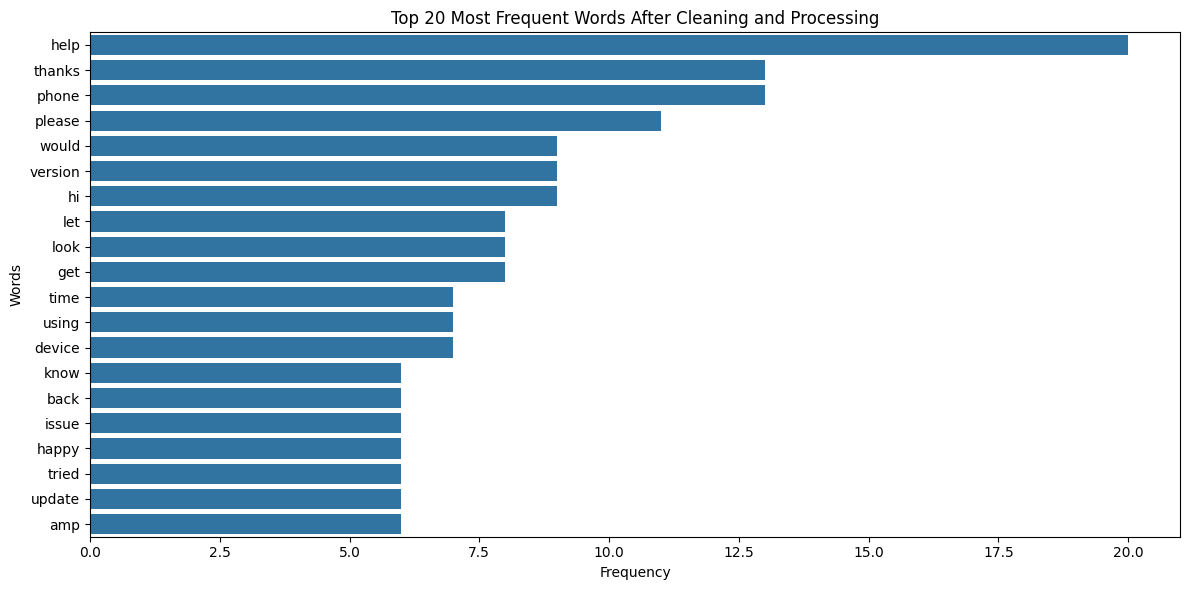

In [19]:
original_vectorizer = CountVectorizer()
original_vectorizer.fit(df['text'])

vectorizer = CountVectorizer(max_features=20)
X = vectorizer.fit_transform(df['processed_text'])

print("Original vocabulary size:", len(original_vectorizer.vocabulary_))
print("Processed vocabulary size:", len(vectorizer.vocabulary_))

freq_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
freq_sum = freq_df.sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=freq_sum.values, y=freq_sum.index)
plt.title("Top 20 Most Frequent Words After Cleaning and Processing")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.tight_layout()
plt.show()


In [20]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf)

def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx+1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

print("\nTop 5 words per LDA topic:")
display_topics(lda, tfidf_vectorizer.get_feature_names_out(), 5)



Top 5 words per LDA topic:
Topic 1:
help, send, happy, look, issue
Topic 2:
please, thanks, name, address, full
Topic 3:
reply, hope, find, miriam, answer
Topic 4:
version, help, update, phone, problem
Topic 5:
get, time, week, battery, tried


In [21]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters, random_state=42)
clusters = km.fit_predict(tfidf)
df['cluster'] = clusters

print("\nCluster distribution:")
print(df['cluster'].value_counts())



Cluster distribution:
cluster
4    89
2     1
0     1
1     1
3     1
Name: count, dtype: int64


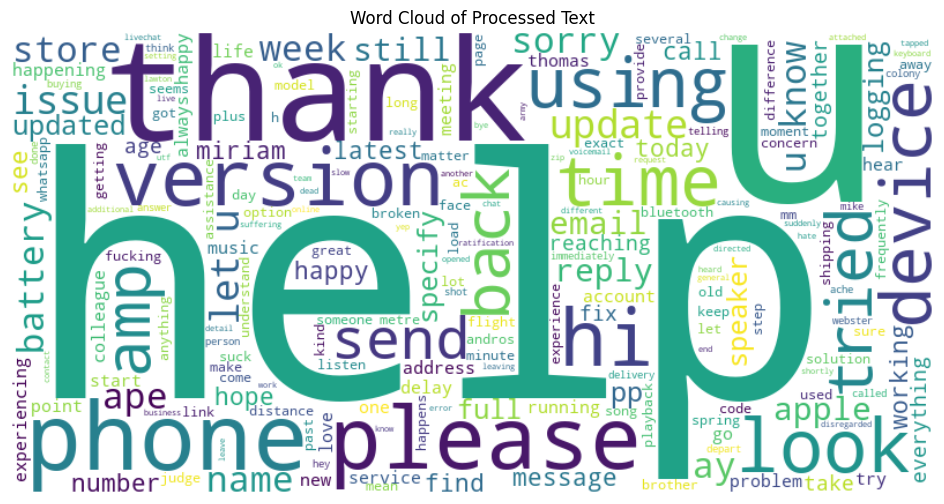

In [22]:
text_combined = " ".join(df['processed_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Processed Text")
plt.show()


In [24]:
# Save the cleaned DataFrame to a local file in the project directory
df.to_csv("Output.csv", index=False)

# Save the text analysis report
with open("text_analysis_report.txt", "w") as f:
    f.write("Text Analytics Data Quality Report\n\n")

    f.write(f"Original vocabulary size: {len(original_vectorizer.vocabulary_)}\n")
    f.write(f"Processed vocabulary size: {len(vectorizer.vocabulary_)}\n")
    f.write(f"Average original word count: {df['original_word_count'].mean():.2f}\n")
    f.write(f"Average cleaned word count: {df['cleaned_word_count'].mean():.2f}\n")
    f.write(f"Average processed word count: {df['processed_word_count'].mean():.2f}\n\n")

    f.write("Sample Named Entities and POS Tags (first 5 rows):\n")
    for idx, row in df.head(5).iterrows():
        f.write(f"\nRow {idx} NER: {row['ner_pos'][0]}\n")
        f.write(f"Row {idx} POS: {row['ner_pos'][1]}\n")

    f.write("\nTop 5 words per LDA Topic:\n")
    for idx, topic in enumerate(lda.components_):
        top_words = ", ".join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-6 - 1:-1]])
        f.write(f"Topic {idx+1}: {top_words}\n")

    f.write("\nCluster counts:\n")
    f.write(str(df['cluster'].value_counts()))

print("\n✅ Processing and analysis complete! 'Output.csv' and 'text_analysis_report.txt' saved in the project folder.")



✅ Processing and analysis complete! 'Output.csv' and 'text_analysis_report.txt' saved in the project folder.
